# LAA

In [1]:
# Set the path
import sys
sys.path.append("../../")

from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.types import SimulationParameters, ConstantCurrentInjection, FilterParameters, ConductanceOptions, OptimizationParameters
import act.data_processing as dp
from act.module import ACTModule

import numpy as np
import matplotlib.pyplot as plt

from act.passive import ACTPassiveModule
from act.segregation import ACTSegregator

from sklearn.metrics import mean_absolute_error
from act.metrics import pp_error

--No graphics will be displayed.


## 1. Set the "target" model and simulate from it

The "target" model's output represents the target bio data provided by the user to tune for.

Parameters:
...

In [2]:
target_cell = ACTCellModel(
    path_to_hoc_file="/home/ubuntu/ACT/data/LAA/orig/target_template.hoc",
    path_to_mod_files="/home/ubuntu/ACT/data/LAA/orig/modfiles",
    cell_name="Cell_A",
    passive=[],
    active_channels=["gbar_nap",
                     "gmbar_im", 
                     "gbar_na3",
                     "gkdrbar_kdr", 
                     "gcabar_cadyn", 
                     "gsAHPbar_sAHP", 
                     "gkabar_kap",
                     "ghdbar_hd",
                     "glbar_leak"]
)

In [3]:
target_g = np.array([0.0003, 0.002, 0.03, 0.003, 6e-5, 0.009, 0.000843, 2.3e-05, 3.5e-5])

### 1.1. Target passive properties

In [4]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "target",
    sim_idx = 0,
    h_v_init=-70,
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = -0.2, dur = 700, delay = 100)])

simulator.submit_job(target_cell, sim_params)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


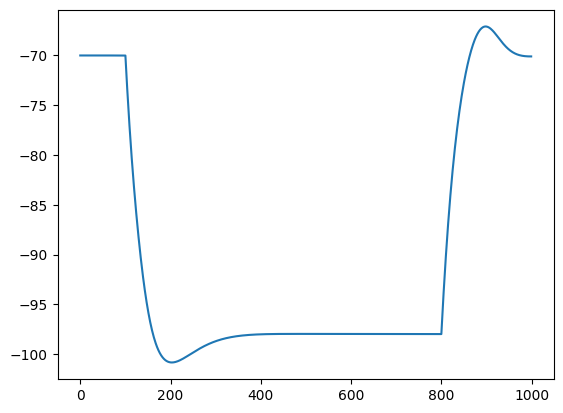

In [5]:
passive_trace = np.load("output/target/out_0.npy")[:, 0]
plt.plot(passive_trace[::10])

In [6]:
target_gpp = ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)
target_gpp

GettablePassiveProperties(R_in=154.08332854492159, tau1=32.1, tau2=79.2, sag_ratio=0.09266348810285467, V_rest=-70.00820628316522)

### 1.2. Target FI curve

In [7]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

for sim_idx, amp_value in enumerate([0.0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.3, 0.5, 0.7, 1.0, 3.0, 5.0, 7.0, 9.0]):
    sim_params = SimulationParameters(
        sim_name = "target",
        sim_idx = sim_idx,
        h_v_init=-70,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100)])

    simulator.submit_job(target_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/target")


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
output/target/combined_out.npy


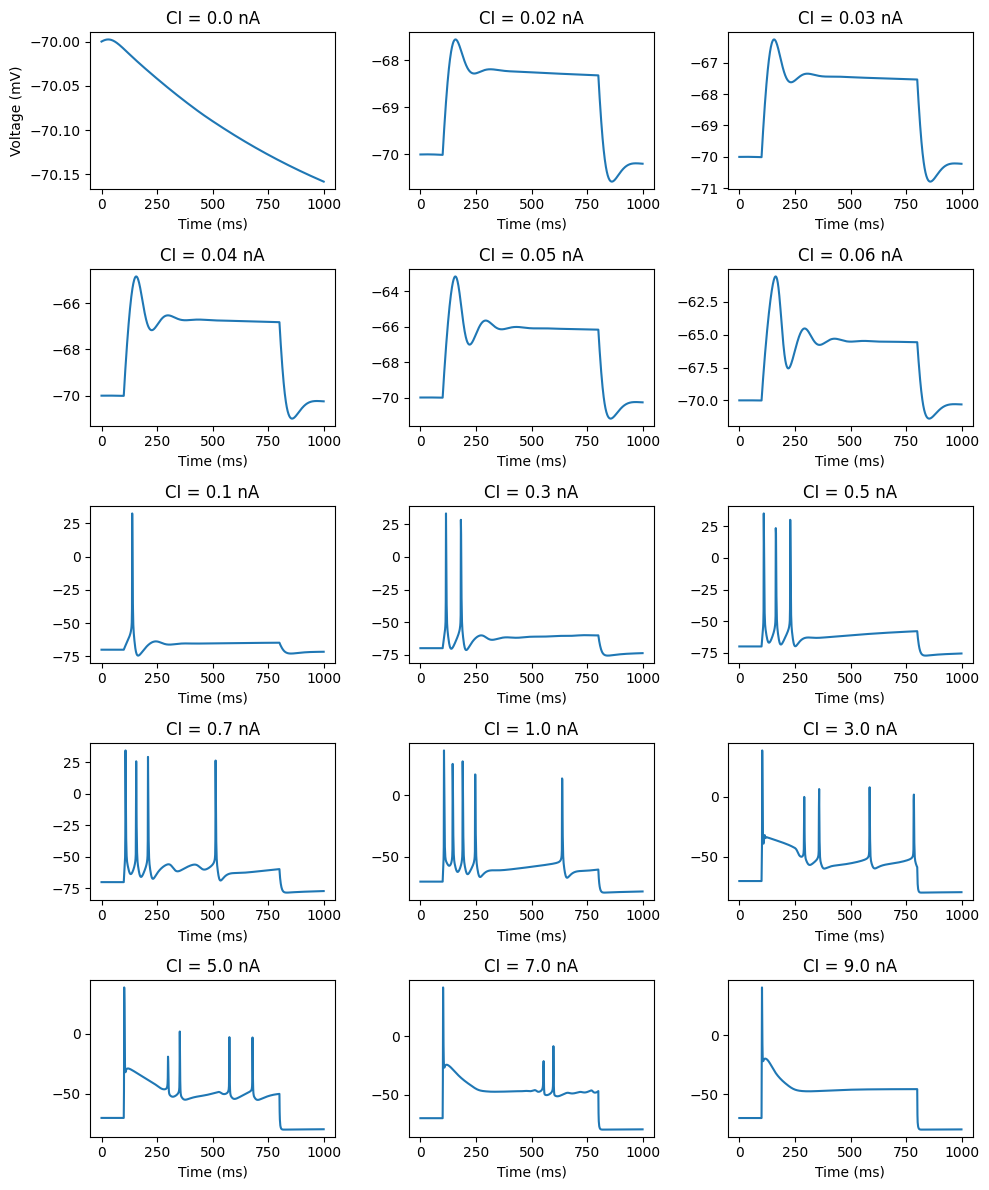

In [8]:
# Plot the traces and the FI curve
simulated_data = np.load("output/target/combined_out.npy") # 3 x 10000 x 4; (n_sim x time x [V, I, g, lto_hto])

fig, ax = plt.subplots(5, 3, figsize = (10, 12))
ax = ax.flatten()

for axid, amp in enumerate([0.0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.3, 0.5, 0.7, 1.0, 3.0, 5.0, 7.0, 9.0]):
    ax[axid].plot(simulated_data[axid, ::10, 0])
    ax[axid].set_xlabel("Time (ms)")
    ax[axid].set_title(f"CI = {amp} nA")

ax[0].set_ylabel("Voltage (mV)")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'FI Curve')

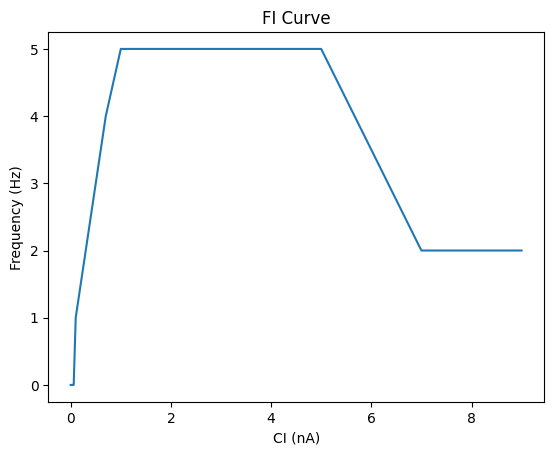

In [9]:
simulated_data = np.load("output/target/combined_out.npy")

f = []
for trace_id in range(len(simulated_data)):
    f.append(len(dp.find_events(simulated_data[trace_id, ::10, 0].flatten())))

plt.plot([0.0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.3, 0.5, 0.7, 1.0, 3.0, 5.0, 7.0, 9.0], f)
plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")

## 2. Original pipeline - optimize passive and active channels together

### 2.1. Set the train cell 

We assume the train cell was acquired from an external source, e.g., AllenDB. Thus, its parameters do not necesserily match those of the target cell. Here we set these parameters to the target's values +- 10% std.

In [10]:
random_state = np.random.RandomState(123)
target_values = np.array([2.5, 0.0003, 0.002, 0.03, 0.003, 6e-5, 0.009, 0.000843, 2.3e-05, 3.5e-5, -70]) 

#Cm, gbar_nap, gmbar_im, gbar_na3, gkdrbar_kdr, gcabar_cadyn, gsAHPbar_sAHP, gkabar_kap, ghdbar_hd, glbar_leak, el_leak

target_values = target_values + random_state.normal(0, np.abs(target_values * 0.1))
target_values

array([ 2.22859235e+00,  3.29920363e-04,  2.05659570e-03,  2.54811159e-02,
        2.82641992e-03,  6.99086192e-05,  6.81598868e-03,  8.06842665e-04,
        2.59116534e-05,  3.19664086e-05, -7.47522031e+01])

Train cell (updated in template.hoc):

- cm = 2.2286
- gbar_nap = 3.299204e-4 (S/cm2)
- gmbar_im = 2.056596e-3 (S/cm2)
- gbar_na3 =2.548112e-2 (S/cm2)
- gkdrbar_kdr = 2.82642e-3 (S/cm2)
- gcabar_cadyn =6.99086e-5 (S/cm2)
- gsAHPbar_sAHP = 6.81599e-3 (S/cm2)
- gkabar_kap = 8.068427e-4 (S/cm2)
- ghdbar_hd = 2.591165e-5 (S/cm2)
- glbar_leak = 3.196641e-5 (S/cm2)
- el_leak = -74.752 (mV)

In [11]:
# Define the train cell
train_cell = ACTCellModel(
    path_to_hoc_file="/home/ubuntu/ACT/data/LAA/orig/template.hoc",
    path_to_mod_files="/home/ubuntu/ACT/data/LAA/orig/modfiles",
    cell_name="Cell_A",
    passive=[],
    active_channels=["gbar_nap",
                     "gmbar_im", 
                     "gbar_na3",
                     "gkdrbar_kdr", 
                     "gcabar_cadyn", 
                     "gsAHPbar_sAHP", 
                     "gkabar_kap",
                     "ghdbar_hd",
                     "glbar_leak"]
)

### 2.2. Passive properties before tuning

In [12]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "orig",
    sim_idx = 0,
    h_v_init=-70,
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = -0.2, dur = 700, delay = 100)])

simulator.submit_job(train_cell, sim_params)
simulator.run_jobs(1)

passive_trace = np.load("output/orig/out_0.npy")[:, 0]
ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


GettablePassiveProperties(R_in=161.39119650863853, tau1=29.1, tau2=73.5, sag_ratio=0.12013561594874832, V_rest=-71.12918300526314)

### 2.3. FI curve before tuning

In [13]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

for sim_idx, amp_value in enumerate([0.0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.3, 0.5, 0.7, 1.0, 3.0, 5.0, 7.0, 9.0]):
    sim_params = SimulationParameters(
        sim_name = "orig",
        sim_idx = sim_idx,
        h_v_init=-70,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100)])

    simulator.submit_job(train_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/orig")


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
output/orig/combined_out.npy


Text(0.5, 1.0, 'FI Curve')

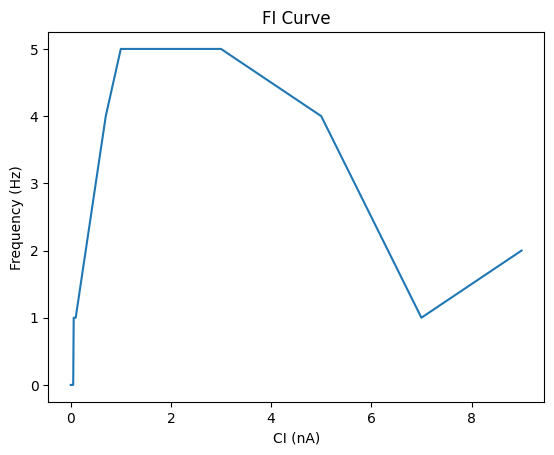

In [14]:
simulated_data = np.load("output/orig/combined_out.npy")

f = []
for trace_id in range(len(simulated_data)):
    f.append(len(dp.find_events(simulated_data[trace_id, ::10, 0].flatten())))

plt.plot([0.0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.3, 0.5, 0.7, 1.0, 3.0, 5.0, 7.0, 9.0], f)
plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")

### 2.4 Optimize

In [15]:
# Parameter ranges as if provided by the user
gbar_nap = 3.299204e-4
gmbar_im = 2.056596e-3 
gbar_na3 =2.548112e-2
gkdrbar_kdr = 2.82642e-3 
gcabar_cadyn =6.99086e-5 
gsAHPbar_sAHP = 6.81599e-3 
gkabar_kap = 8.068427e-4 
ghdbar_hd = 2.591165e-5 
glbar_leak = 3.196641e-5 

random_state = np.random.RandomState(123)

gbar_nap_range = (gbar_nap - random_state.uniform(0, gbar_nap / 2), gbar_nap + random_state.uniform(0, gbar_nap / 2))
gmbar_im_range = (gmbar_im - random_state.uniform(0, gmbar_im / 2), gmbar_im + random_state.uniform(0, gmbar_im / 2))
gbar_na3_range = (gbar_na3 - random_state.uniform(0, gbar_na3 / 2), gbar_na3 + random_state.uniform(0, gbar_na3 / 2))
gkdrbar_kdr_range = (gkdrbar_kdr - random_state.uniform(0, gkdrbar_kdr / 2), gkdrbar_kdr + random_state.uniform(0, gkdrbar_kdr / 2))
gcabar_cadyn_range = (gcabar_cadyn - random_state.uniform(0, gcabar_cadyn / 2), gcabar_cadyn + random_state.uniform(0, gcabar_cadyn / 2))
gsAHPbar_sAHP_range = (gsAHPbar_sAHP - random_state.uniform(0, gsAHPbar_sAHP / 2), gsAHPbar_sAHP + random_state.uniform(0, gsAHPbar_sAHP / 2))
gbar_kap_range = (gkabar_kap - random_state.uniform(0, gkabar_kap / 2), gkabar_kap + random_state.uniform(0, gkabar_kap / 2))
ghdbar_hd_range = (ghdbar_hd - random_state.uniform(0, ghdbar_hd / 2), ghdbar_hd + random_state.uniform(0, ghdbar_hd / 2))
glbar_leak_range = (glbar_leak - random_state.uniform(0, glbar_leak / 2), glbar_leak + random_state.uniform(0, glbar_leak / 2))


print(f"Nap: {gbar_nap_range}")
print(f"Nap: {gmbar_im_range}")
print(f"Na3: {gbar_na3_range}")
print(f"Kdr: {gkdrbar_kdr_range}")
print(f"Cadyn: {gcabar_cadyn_range}")
print(f"sAHP: {gsAHPbar_sAHP_range}")
print(f"Kap: {gbar_kap_range}")
print(f"Hd: {ghdbar_hd_range}")
print(f"Leak: {glbar_leak_range}")

Nap: (0.00021503070384993963, 0.00037712200192128163)
Nap: (0.001823325104002837, 0.002623511874418399)
Na3: (0.016314682422308845, 0.030871733241603302)
Kdr: (0.0014403942272008777, 0.003794228234865515)
Cadyn: (5.30979620359452e-05, 8.361479336621379e-05)
sAHP: (0.005646441036847917, 0.009300587757516278)
Kap: (0.0006299132929788156, 0.0008309180376153925)
Hd: (2.0754658285683615e-05, 3.547298932746825e-05)
Leak: (2.9049607261356966e-05, 3.4770691386115386e-05)


In [16]:
# Possibly adjsut
train_cell = ACTCellModel(
    path_to_hoc_file="/home/ubuntu/ACT/data/LAA/orig/template.hoc",
    path_to_mod_files="/home/ubuntu/ACT/data/LAA/orig/modfiles",
    cell_name="Cell_A",
    passive=[],
    active_channels=["gbar_nap",
                     "gmbar_im", 
                     "gbar_na3",
                     "gkdrbar_kdr", 
                     "gcabar_cadyn", 
                     "gsAHPbar_sAHP", 
                     "gkabar_kap",
                     "ghdbar_hd",
                     "glbar_leak"]
)

In [ ]:
from multiprocessing import Pool, cpu_count
sim_params = SimulationParameters(
        sim_name = "cell",
        sim_idx = 0,
        h_v_init=-70,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000)

optim_params = OptimizationParameters(
    conductance_options = [
        ConductanceOptions(variable_name = "gbar_nap", low = gbar_nap_range[0], high = gbar_nap_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "gmbar_im", low = gmbar_im_range[0], high = gmbar_im_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "gbar_na3", low = gbar_na3_range[0], high = gbar_na3_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "gkdrbar_kdr", low = gkdrbar_kdr_range[0], high = gkdrbar_kdr_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "gcabar_cadyn", low = gcabar_cadyn_range[0], high = gcabar_cadyn_range[1], n_slices = 3),  
        ConductanceOptions(variable_name = "gsAHPbar_sAHP", low = gsAHPbar_sAHP_range[0], high = gsAHPbar_sAHP_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "gkabar_kap", low = gbar_kap_range[0], high = gbar_kap_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "ghdbar_hd", low = ghdbar_hd_range[0], high = ghdbar_hd_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "glbar_leak", low = glbar_leak_range[0], high = glbar_leak_range[1], n_slices = 3)
    ],
    CI_options = [
        ConstantCurrentInjection(amp = 0.0, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.02, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.03, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.04, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.05, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.06, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.3, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.7, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 1.0, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 3.0, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 5.0, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 7.0, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 9.0, dur = 700, delay = 100)
    ],
    filter_parameters = FilterParameters(
        saturation_threshold = -55,
        window_of_inspection = (100, 700)
    ),
    n_cpus=30
)

m = ACTModule(
    name = "orig",
    cell = train_cell,
    simulation_parameters = sim_params,
    optimization_parameters = optim_params,
    target_file = "output/target/combined_out.npy"
)

In [ ]:
m.run()

Running Module 'orig'...
----------
Simulating train traces...

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [ ]:
orig_g = np.array(list(m.cell.prediction.values()))

In [ ]:
# Test g error
mean_absolute_error(target_g, orig_g)

### 2.5. Passive properties after tuning

In [ ]:
train_cell = ACTCellModel(
    path_to_hoc_file="/home/ubuntu/ACT/data/LAA/orig/template.hoc",
    path_to_mod_files="/home/ubuntu/ACT/data/LAA/orig/modfiles",
    cell_name="Cell_A",
    passive=[],
    active_channels=["gbar_nap",
                     "gmbar_im", 
                     "gbar_na3",
                     "gkdrbar_kdr", 
                     "gcabar_cadyn", 
                     "gsAHPbar_sAHP", 
                     "gkabar_kap",
                     "ghdbar_hd",
                     "glbar_leak"]
)

In [ ]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "laa_orig_after",
    sim_idx = 0,
    h_v_init=-70,
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = -0.2, dur = 700, delay = 100)])

train_cell.set_g_bar(["gbar_nap",
                     "gmbar_im", 
                     "gbar_na3",
                     "gkdrbar_kdr", 
                     "gcabar_cadyn", 
                     "gsAHPbar_sAHP", 
                     "gkabar_kap",
                     "ghdbar_hd",
                     "glbar_leak"], orig_g)

simulator.submit_job(train_cell, sim_params)
simulator.run_jobs(1)

passive_trace = np.load("output/laa_orig_after/out_0.npy")[:, 0]
ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)

In [ ]:
orig_gpp = ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)
orig_gpp

In [ ]:
pp_error(target_gpp, orig_gpp)

### 2.6. FI curve after tuning

In [ ]:
train_cell = ACTCellModel(
    path_to_hoc_file="/home/ubuntu/ACT/data/LAA/orig/template.hoc",
    path_to_mod_files="/home/ubuntu/ACT/data/LAA/orig/modfiles",
    cell_name="Cell_A",
    passive=[],
    active_channels=["gbar_nap",
                     "gmbar_im", 
                     "gbar_na3",
                     "gkdrbar_kdr", 
                     "gcabar_cadyn", 
                     "gsAHPbar_sAHP", 
                     "gkabar_kap",
                     "ghdbar_hd",
                     "glbar_leak"]
)

In [ ]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")


for sim_idx, amp_value in enumerate([0.0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.3, 0.5, 0.7, 1.0, 3.0, 5.0, 7.0, 9.0]):
    sim_params = SimulationParameters(
        sim_name = "laa_orig_after",
        sim_idx = sim_idx,
        h_v_init=-70,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100)])
    
    train_cell.set_g_bar(["gbar_nap",
                        "gmbar_im", 
                        "gbar_na3",
                        "gkdrbar_kdr", 
                        "gcabar_cadyn", 
                        "gsAHPbar_sAHP", 
                        "gkabar_kap",
                        "ghdbar_hd",
                        "glbar_leak"], orig_g)


    simulator.submit_job(train_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/laa_orig_after")

In [ ]:
simulated_data = np.load("output/laa_orig_after/combined_out.npy")

f = []
for trace_id in range(len(simulated_data)):
    f.append(len(dp.find_events(simulated_data[trace_id, ::10, 0].flatten())))

plt.plot([0.0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.3, 0.5, 0.7, 1.0, 3.0, 5.0, 7.0, 9.0], f)
plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")